# Introducción
En este proyecto, asumimos el rol de analista de datos para una gran tienda en línea. Nuestro objetivo principal es aumentar los ingresos de la tienda, para ello trabajamos en estrecha colaboración con el departamento de marketing para evaluar una serie de hipótesis. Estas hipótesis, se basan en diferentes estrategias de negocio, se evaluarán y priorizarán con el fin de identificar las más prometedoras.

El proyecto se divide en dos partes:

1. Priorización de Hipótesis:
En la primera parte del proyecto, se nos presenta un conjunto de nueve hipótesis que podrían impactar los ingresos de la tienda. Para priorizar estas hipótesis, aplicaremos dos marcos de decisión comúnmente utilizados en la toma de decisiones empresariales: ICE (Impacto, Confianza y Esfuerzo) y RICE (Alcance, Impacto, Confianza y Esfuerzo). El análisis nos permitirá comprender cuáles de estas hipótesis tienen el mayor potencial para ser implementadas primero y cómo la inclusión del factor "Alcance" (Reach) en el marco RICE puede influir en las decisiones de priorización.

2. Análisis de un Test A/B:
En la segunda parte del proyecto, realizaremos un análisis detallado de un test A/B que ya ha sido ejecutado. Este test A/B tiene como objetivo comparar dos grupos de usuarios (Grupo A y Grupo B) para determinar cuál de las estrategias probadas es más efectiva para incrementar los ingresos. Utilizando los datos de pedidos y visitas, analizaremos diferentes métricas como los ingresos acumulados, el tamaño promedio de los pedidos, la tasa de conversión, y más. A lo largo del análisis, se identificará la significancia estadística de las diferencias observadas, lo que nos permitirá tomar decisiones basadas en datos sobre cuál de las estrategias debería ser adoptada.

Al final del proyecto, seremos capaces de priorizar las hipótesis con mayor impacto potencial y tomar decisiones informadas basadas en los resultados del test A/B, contribuyendo así a la mejora continua de las estrategias de negocio de la tienda.

In [1]:
# Inicializacion
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats as st
from statsmodels.stats.proportion import proportions_ztest
from scipy.stats import ttest_ind, mannwhitneyu

# Descargar los datos y prepárarlos para el análisis. 

In [2]:
# Cargar los datos
hypothesis = pd.read_csv('/datasets/hypotheses_us.csv')
orders = pd.read_csv('/datasets/orders_us.csv')
visitors = pd.read_csv('/datasets/visits_us.csv')

# Verificar la información de los datasets
hypothesis.info()
orders.info()
visitors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 1 columns):
 #   Column                                     Non-Null Count  Dtype 
---  ------                                     --------------  ----- 
 0   Hypothesis;Reach;Impact;Confidence;Effort  9 non-null      object
dtypes: object(1)
memory usage: 200.0+ bytes
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   transactionId  1197 non-null   int64  
 1   visitorId      1197 non-null   int64  
 2   date           1197 non-null   object 
 3   revenue        1197 non-null   float64
 4   group          1197 non-null   object 
dtypes: float64(1), int64(2), object(2)
memory usage: 46.9+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------

# Observaciones para la muestras de datos

El dataset hypothesis tiene un problema evidente de formato, ya que toda la información está contenida en una única columna denominada "Hypothesis; Reach; Impact; Confidence; Effort". Esto sugiere que los datos no se han separado adecuadamente en múltiples columnas, lo que impide su análisis directo. Antes de poder aplicar cualquier modelo o realizar un análisis (como la priorización mediante ICE o RICE), es esencial dividir esta columna en múltiples columnas separadas (es decir, Hypothesis, Reach, Impact, Confidence, Effort). El dataset tiene solo 9 entradas, lo cual es adecuado para el propósito de priorización, pero limita la variabilidad en los datos.

El dataset de orders cuenta con 1197 entradas, sin valores nulos en ninguna de las columnas, lo cual es positivo y facilita el análisis, las columnas transactionId y visitorId son del tipo entero (int64), lo que es apropiado, mientras que revenue es un valor numérico de punto flotante (float64), adecuado para manejar los ingresos. Sin embargo, la columna date es de tipo object, lo que sugiere que aún no ha sido convertida a un formato de fecha y hora, necesario para el análisis temporal.

Las columnas group y revenue serán esenciales para comparar los resultados de los grupos A/B y determinar la efectividad de las estrategias en términos de ingresos.


El dataset de visitas es considerablemente más pequeño, con solo 62 entradas. Esto sugiere que representa datos agregados o un periodo de tiempo limitado, no hay valores nulos, lo que facilita el análisis. Similar al dataset de pedidos, la columna date también es de tipo object, lo que indica que se requiere una conversión a un formato de fecha para facilitar el análisis temporal.

La columna visits será crucial para calcular la tasa de conversión de cada grupo, que es una métrica fundamental en el análisis de test A/B.

# Conclusiones Generales:

Antes de realizar cualquier análisis, se requiere un preprocesamiento significativo de los datos, particularmente para separar las columnas en el dataset de hipótesis y convertir las columnas de fecha en los datasets de pedidos y visitas.
Preparación Adecuada: Los datasets de pedidos y visitas parecen estar en buen estado para el análisis estadístico y la visualización, pero se necesitarán ajustes menores (como la conversión de fechas y convertir las columnas a snake_case).

In [3]:
# Separar las columnas del dataset hypotesis
hypothesis = pd.read_csv('/datasets/hypotheses_us.csv', sep = ';')

# Cambiar el Dtype de la columna date usando el formato correcto
orders['date'] = orders['date'].map(lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))
visitors['date'] = visitors['date'].map(lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))


# Convertir nombres de columnas a snake_case
hypothesis.columns = hypothesis.columns.str.lower()
orders.columns = ['transaction_id', 'visitor_id', 'date', 'revenue', 'group']

In [4]:
# Imprime la informacion general/resumida sobre el df hypothesis
hypothesis.info()
display(hypothesis.head())
hypothesis.duplicated().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   hypothesis  9 non-null      object
 1   reach       9 non-null      int64 
 2   impact      9 non-null      int64 
 3   confidence  9 non-null      int64 
 4   effort      9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes


,hypothesis,reach,impact,confidence,effort
0,Add two new channels for attracting traffic. T...,3,10,8,6
1,Launch your own delivery service. This will sh...,2,5,4,10
2,Add product recommendation blocks to the store...,8,3,7,3
3,Change the category structure. This will incre...,8,3,3,8
4,Change the background color on the main page. ...,3,1,1,1


0

In [5]:
# Imprime la informacion general/resumida sobre el df orders
orders.info()
display(orders.head())
orders.duplicated().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   transaction_id  1197 non-null   int64         
 1   visitor_id      1197 non-null   int64         
 2   date            1197 non-null   datetime64[ns]
 3   revenue         1197 non-null   float64       
 4   group           1197 non-null   object        
dtypes: datetime64[ns](1), float64(1), int64(2), object(1)
memory usage: 46.9+ KB


,transaction_id,visitor_id,date,revenue,group
0,3667963787,3312258926,2019-08-15,30.4,B
1,2804400009,3642806036,2019-08-15,15.2,B
2,2961555356,4069496402,2019-08-15,10.2,A
3,3797467345,1196621759,2019-08-15,155.1,B
4,2282983706,2322279887,2019-08-15,40.5,B


0

In [6]:
# Imprime la informacion general/resumida sobre el df visits
visitors.info()
display(visitors.head())
visitors.duplicated().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    62 non-null     datetime64[ns]
 1   group   62 non-null     object        
 2   visits  62 non-null     int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 1.6+ KB


,date,group,visits
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


0

In [7]:
# Filtrar visitantes por grupo
group_a = orders[orders['group'] == 'A']['visitor_id']
group_b = orders[orders['group'] == 'B']['visitor_id']

# Encontrar visitantes que están en ambos grupos
duplicated_visitors = pd.Series(list(set(group_a) & set(group_b)))

# Filtrar los pedidos para eliminar estos visitantes
orders = orders[~orders['visitor_id'].isin(duplicated_visitors)]

orders.head()

,transaction_id,visitor_id,date,revenue,group
0,3667963787,3312258926,2019-08-15,30.4,B
1,2804400009,3642806036,2019-08-15,15.2,B
3,3797467345,1196621759,2019-08-15,155.1,B
4,2282983706,2322279887,2019-08-15,40.5,B
5,182168103,935554773,2019-08-15,35.0,B


In [8]:
# Verifica si hay datos faltantes
display(orders.isnull().sum())
display(visitors.isnull().sum())

transaction_id    0
visitor_id        0
date              0
revenue           0
group             0
dtype: int64

date      0
group     0
visits    0
dtype: int64

##  Priorizar hipótesis.

In [9]:
# Calcular el puntaje ICE
hypothesis['ICE'] = (hypothesis['impact'] * hypothesis['confidence']) / hypothesis['effort']

# Ordenar las hipótesis por puntaje ICE en orden descendente
hypothesis_ice_sorted = hypothesis.sort_values(by='ICE', ascending=False)

# Mostrar el resultado
hypothesis_ice_sorted[['hypothesis', 'ICE']]

,hypothesis,ICE
8,Launch a promotion that gives users discounts ...,16.200000
0,Add two new channels for attracting traffic. T...,13.333333
7,Add a subscription form to all the main pages....,11.200000
6,Show banners with current offers and sales on ...,8.000000
2,Add product recommendation blocks to the store...,7.000000
1,Launch your own delivery service. This will sh...,2.000000
5,Add a customer review page. This will increase...,1.333333
3,Change the category structure. This will incre...,1.125000
4,Change the background color on the main page. ...,1.000000


In [10]:
# Calcular el puntaje RICE
hypothesis['RICE'] = (hypothesis['reach'] * hypothesis['impact'] * hypothesis['confidence']) / hypothesis['effort']

# Ordenar las hipótesis por puntaje RICE en orden descendente
hypothesis_rice_sorted = hypothesis.sort_values(by='RICE', ascending=False)

# Mostrar el resultado
hypothesis_rice_sorted[['hypothesis', 'RICE']]

,hypothesis,RICE
7,Add a subscription form to all the main pages....,112.0
2,Add product recommendation blocks to the store...,56.0
0,Add two new channels for attracting traffic. T...,40.0
6,Show banners with current offers and sales on ...,40.0
8,Launch a promotion that gives users discounts ...,16.2
3,Change the category structure. This will incre...,9.0
1,Launch your own delivery service. This will sh...,4.0
5,Add a customer review page. This will increase...,4.0
4,Change the background color on the main page. ...,3.0


In [11]:
# Comparar los rankings de ICE y RICE
comparison = hypothesis[['hypothesis', 'ICE', 'RICE']].sort_values(by='ICE', ascending=False)
comparison

,hypothesis,ICE,RICE
8,Launch a promotion that gives users discounts ...,16.200000,16.2
0,Add two new channels for attracting traffic. T...,13.333333,40.0
7,Add a subscription form to all the main pages....,11.200000,112.0
6,Show banners with current offers and sales on ...,8.000000,40.0
2,Add product recommendation blocks to the store...,7.000000,56.0
1,Launch your own delivery service. This will sh...,2.000000,4.0
5,Add a customer review page. This will increase...,1.333333,4.0
3,Change the category structure. This will incre...,1.125000,9.0
4,Change the background color on the main page. ...,1.000000,3.0


# Conclusión sobre los Resultados de la Prioritización de Hipótesis usando ICE y RICE

La tabla presentada muestra los resultados de la priorización de hipótesis utilizando dos frameworks: ICE (Impacto, Confianza, Esfuerzo) y RICE (Alcance, Impacto, Confianza, Esfuerzo). A continuación se detallan las principales conclusiones:

Impacto del Alcance en la Prioridad: El framework RICE incluye el factor Reach (Alcance), lo que provoca un cambio significativo en la priorización de las hipótesis en comparación con ICE. Por ejemplo, la hipótesis "Agregar un formulario de suscripción a todas las páginas principales" tiene un ICE de 11.2 y ocupa una posición media en la lista. Sin embargo, en RICE, su valor se eleva a 112.0, colocándola como una de las hipótesis más prioritarias. Esto indica que el alcance de esta hipótesis es considerablemente alto, lo que aumenta su importancia cuando se considera en RICE.

Consistencia en la Hipótesis Principal: La hipótesis "Lanzar una promoción que ofrezca a los usuarios descuentos" mantiene su posición como una de las más prioritarias tanto en ICE como en RICE (16.2 en ambos). Esto sugiere que esta idea tiene un alto impacto y confianza, y que su alcance y esfuerzo son apropiados.

Discrepancias entre ICE y RICE: La mayor discrepancia entre los dos métodos se observa en la hipótesis "Agregar dos nuevos canales para atraer tráfico". Con un ICE de 13.33, es la segunda más alta en la lista, pero con RICE (40.0), aunque sigue siendo importante, no está en la cima. Esto puede deberse a un alcance moderado en comparación con otras hipótesis.

Hipótesis de Bajo Impacto: Las hipótesis que implican cambios menores, como "Cambiar la estructura de categorías" y "Cambiar el color de fondo en la página principal", tienen puntajes bajos en ambos frameworks, indicando que no son prioritarias. Estas hipótesis probablemente tienen un bajo impacto y un alcance limitado.

# Conclusión Final
La introducción del alcance en el análisis con RICE permite una priorización más completa, destacando hipótesis que, aunque podrían parecer menos impactantes bajo ICE, son críticas debido a su capacidad para llegar a una amplia audiencia. La hipótesis sobre agregar un formulario de suscripción se destaca como la de mayor prioridad en RICE, reflejando su potencial de alto alcance. Este análisis refuerza la importancia de considerar múltiples factores al priorizar acciones estratégicas en un negocio, y sugiere que las decisiones basadas en RICE podrían ser más alineadas con objetivos de largo alcance y gran escala.

## Análisis de test A/B

In [12]:
# Creación de grupos por fechas
dates_groups = orders[['date','group']].drop_duplicates()

# Agregación de Pedidos
orders_aggregated = dates_groups.apply(
    lambda x: orders[np.logical_and(orders['date'] <= x['date'], orders['group'] == x['group'])].agg({
        'date' : 'max',
        'group' : 'max',
        'transaction_id' : pd.Series.nunique,
        'visitor_id' : pd.Series.nunique,
        'revenue' : 'sum'}), axis=1).sort_values(by=['date','group'])

# Agregación de Visitantes
visitors_aggregated = dates_groups.apply(
    lambda x: visitors[np.logical_and(visitors['date'] <= x['date'], visitors['group'] == x['group'])].agg({
        'date' : 'max', 
        'group' : 'max', 
        'visits' : 'sum'}), axis=1).sort_values(by=['date','group'])

# Combinación de Datos Acumulados
cumulative_data = orders_aggregated.merge(visitors_aggregated, left_on=['date', 'group'], right_on=['date', 'group'])
cumulative_data.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']

# DataFrame con pedidos acumulados e ingresos acumulados por día, grupo A
cumulative_revenue_A = cumulative_data[cumulative_data['group']=='A'][['date','revenue', 'orders']]

# DataFrame con pedidos acumulados e ingresos acumulados por día, grupo B
cumulative_revenue_B = cumulative_data[cumulative_data['group']=='B'][['date','revenue', 'orders']]

# Reunir los datos
cumulative_revenue = cumulative_revenue_A.merge(cumulative_revenue_B, left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

# Visualización del Resultado Final
cumulative_data.head()



,date,group,orders,buyers,revenue,visitors
0,2019-08-01,A,23,19,2266.6,719
1,2019-08-01,B,17,17,967.2,713
2,2019-08-02,A,42,36,3734.9,1338
3,2019-08-02,B,40,39,3535.3,1294
4,2019-08-03,A,66,60,5550.1,1845


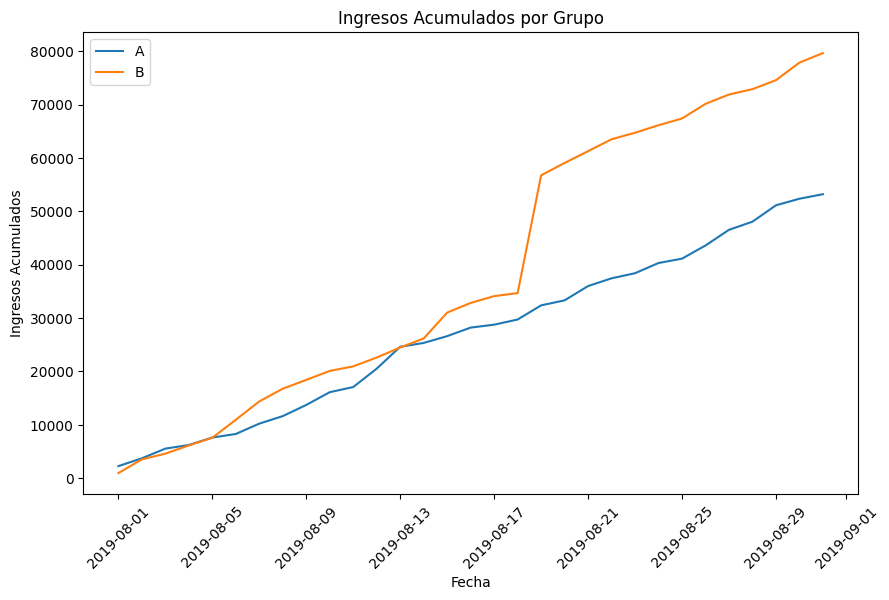

In [13]:
# Trazar el gráfico de ingresos del grupo A
plt.figure(figsize=(10, 6))
plt.plot(cumulative_revenue_A['date'], cumulative_revenue_A['revenue'], label='A')

# Trazar el gráfico de ingresos del grupo B
plt.plot(cumulative_revenue_B['date'], cumulative_revenue_B['revenue'], label='B')

plt.title('Ingresos Acumulados por Grupo')
plt.xlabel('Fecha')
plt.ylabel('Ingresos Acumulados')
plt.legend()
plt.xticks(rotation=45)
plt.show()

# Ingresos Acumulados por Grupo:
El gráfico muestra los ingresos acumulados a lo largo del tiempo para los grupos A y B, se observa que el Grupo B ha generado consistentemente mayores ingresos acumulados en comparación con el Grupo A. Esto sugiere que las modificaciones o estrategias aplicadas al Grupo B han sido más efectivas para aumentar los ingresos. Sin embargo, la diferencia significativa en ingresos podría estar influenciada por varios factores, que deben analizarse en detalle.

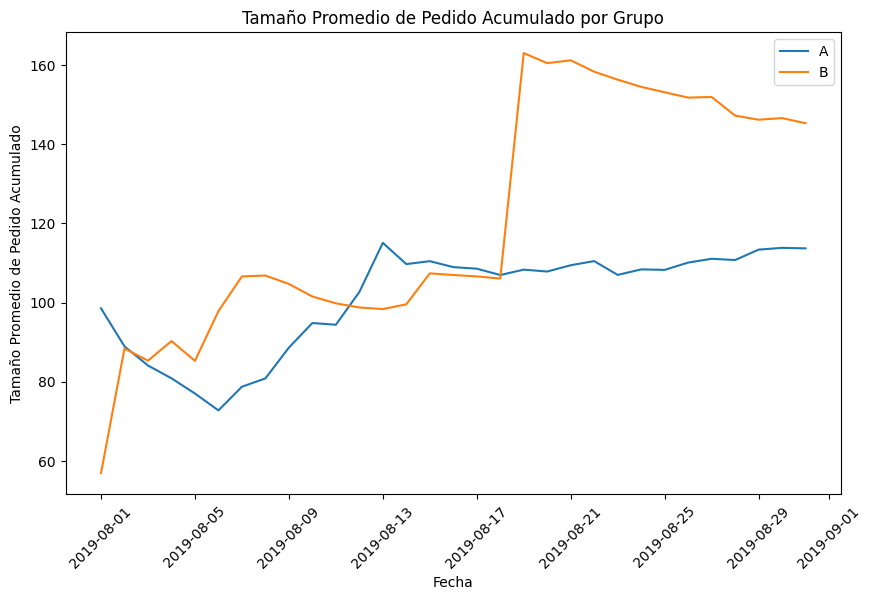

In [14]:
plt.figure(figsize=(10, 6))
plt.plot(cumulative_revenue_A['date'], cumulative_revenue_A['revenue']/cumulative_revenue_A['orders'], label='A')
plt.plot(cumulative_revenue_B['date'], cumulative_revenue_B['revenue']/cumulative_revenue_B['orders'], label='B')
plt.title('Tamaño Promedio de Pedido Acumulado por Grupo')
plt.xlabel('Fecha')
plt.ylabel('Tamaño Promedio de Pedido Acumulado')
plt.legend()
plt.xticks(rotation=45)
plt.show()

# Tamaño de Pedido Promedio:
Al principio, ambos grupos tienen un ingreso promedio bastante similar en términos de ingrsos de pedidos promedio. Sin embargo, después del 17 de agosto, el Grupo B muestra un aumento significativo en los pedidos promedios, lo que podría indicar que alguna intervención tuvo un impacto positivo en este grupo.

A lo largo del período observado, el Grupo A tiene una tendencia más estable y menos volátil en cuanto a pedidos promedio. No hay cambios bruscos, lo que sugiere que no hubo un gran impacto en este grupo o que los pedido se mantuvieron consistentes. El aumento brusco observado en el Grupo B alrededor del 17 de agosto podría indicar una anomalía o un cambio significativo, como un gran pedido aislado o una serie de pedidos más costosos. Después de este punto, aunque el ingreso promedio en el Grupo B disminuye ligeramente, sigue siendo más alto que en el Grupo A.

En general, después del 17 de agosto, el Grupo B mantiene ingresos promedio por pedido más altos que el Grupo A, lo que podría sugerir que las modificaciones aplicadas al Grupo B fueron más efectivas en términos de generar ingresos por pedido.

El pico en el Grupo B sugiere que podría haber outliers o eventos excepcionales que deberían investigarse más a fondo para determinar si son representativos o si deberían excluirse del análisis, identificar qué cambios se implementaron específicamente el 17 de agosto o cerca de esa fecha para entender mejor qué pudo haber causado la variación en el Grupo B.

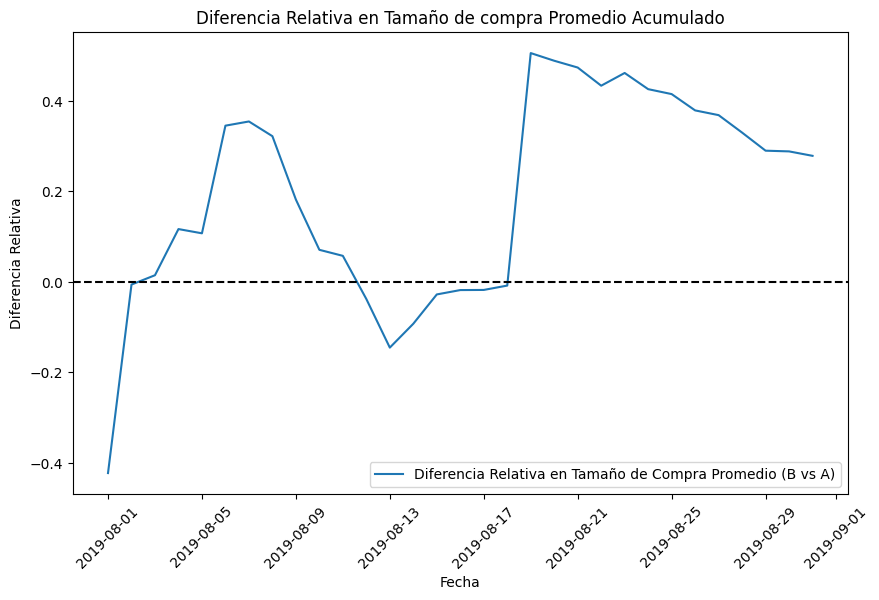

In [15]:
# trazar un gráfico de diferencia relativa para los tamaños de compra promedio
plt.figure(figsize=(10, 6))
plt.plot(cumulative_revenue['date'], (cumulative_revenue['revenueB']/cumulative_revenue['ordersB'])/(cumulative_revenue['revenueA']/cumulative_revenue['ordersA'])-1, label='Diferencia Relativa en Tamaño de Compra Promedio (B vs A)' )
plt.axhline(y=0, color='black', linestyle='--')
plt.title('Diferencia Relativa en Tamaño de compra Promedio Acumulado')
plt.xlabel('Fecha')
plt.ylabel('Diferencia Relativa')
plt.legend()
plt.xticks(rotation=45)
plt.show()

,date,group,transaction_id,visits,conversion_rate
0,2019-08-01,A,23,719,0.031989
1,2019-08-01,B,17,713,0.023843
2,2019-08-02,A,19,619,0.030695
3,2019-08-02,B,23,581,0.039587
4,2019-08-03,A,24,507,0.047337


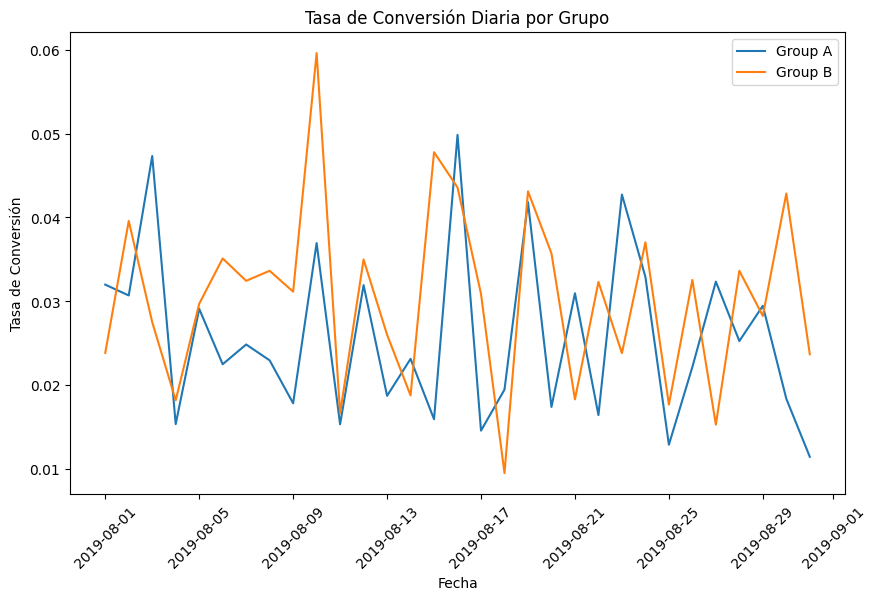

In [16]:
# Calcular la tasa de conversión diaria
daily_orders = orders.groupby(['date', 'group']).agg({'transaction_id': 'count'}).reset_index()
daily_visitors = visitors.groupby(['date', 'group']).agg({'visits': 'sum'}).reset_index()
conversion = pd.merge(daily_orders, daily_visitors, on=['date', 'group'])
conversion['conversion_rate'] = conversion['transaction_id'] / conversion['visits']

display(conversion.head())

# Graficar las tasas de conversión diarias
plt.figure(figsize=(10, 6))
for group in conversion['group'].unique():
    plt.plot(conversion[conversion['group'] == group]['date'],
             conversion[conversion['group'] == group]['conversion_rate'],
             label=f'Group {group}')

plt.title('Tasa de Conversión Diaria por Grupo')
plt.xlabel('Fecha')
plt.ylabel('Tasa de Conversión')
plt.legend()
plt.xticks(rotation=45)
plt.show()

# Gráfico de Tasa de Conversión Diaria por Grupo:
Este gráfico muestra la tasa de conversión diaria para el porcentaje de usuarios que completaron una acción específica, como una compra, para dos grupos diferentes Group A y Group B. Se observa que ambas líneas tienen una alta variabilidad, con algunas fechas donde la tasa de conversión es considerablemente mayor en un grupo en comparación con el otro, la fluctuación en las líneas sugiere que los resultados de las tasas de conversión no son constantes y pueden estar influenciados por varios factores.
La comparación entre ambos grupos a lo largo del tiempo puede ayudar a entender si uno de los grupos tiene un rendimiento consistentemente mejor o si las diferencias son aleatorias.

,visitor_id,transaction_id
0,5114589,1
1,6958315,1
2,11685486,1
3,39475350,1
4,47206413,1


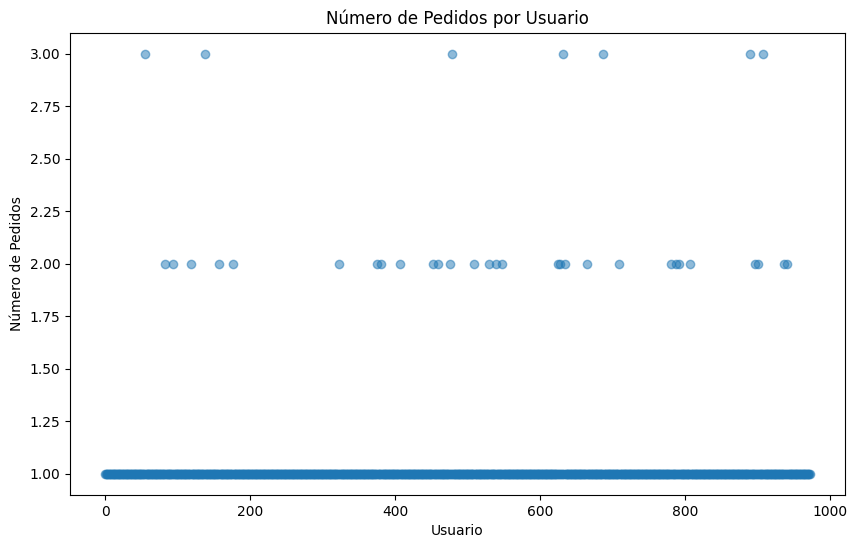

In [17]:
# Calcular el número de pedidos por usuario
orders_per_user = orders.groupby('visitor_id').agg({'transaction_id': 'count'}).reset_index()

display(orders_per_user.head())

# Graficar el número de pedidos por usuario
plt.figure(figsize=(10, 6))
plt.scatter(range(len(orders_per_user)), orders_per_user['transaction_id'], alpha=0.5)
plt.title('Número de Pedidos por Usuario')
plt.xlabel('Usuario')
plt.ylabel('Número de Pedidos')
plt.show()

# Gráfico de Dispersión por Número de Pedidos por Usuarios:
Mayoría de los usuarios realizan un solo pedido: La gran mayoría de los puntos están en la línea de 1 pedido, lo que sugiere que la mayoría de los usuarios han realizado un solo pedido. Esto es bastante común en muchos negocios, donde la mayoría de los clientes realizan una compra única.

Hay un número más pequeño de usuarios que han realizado 2 o 3 pedidos. Estos puntos están más dispersos en las líneas correspondientes a 2 y 3 en el eje Y, estos usuarios recurrentes podrían ser clientes leales, y podría ser útil identificarlos para campañas de retención o marketing personalizado.

No hay un incremento significativo en el número de pedidos a medida que se avanza en el eje X, lo que indica que los pedidos no están concentrados en unos pocos usuarios, sino que están bastante distribuidos entre los usuarios.

El hecho de que la mayoría de los puntos se encuentren en las líneas de 1 a 3 pedidos sugiere que hay poca variabilidad en el número de pedidos por usuario. No se observan usuarios con más de 3 pedidos, lo que podría indicar que no hay una fuerte tendencia de usuarios que realicen múltiples compras.

# Conclusión
Dado que la mayoría de los usuarios realizan solo un pedido, una estrategia para incentivar compras adicionales podría ser beneficiosa. Los usuarios que hacen 2 o 3 pedidos podrían representar una base importante para el negocio y tal vez convendría implementar programas de fidelización para aumentar su número de compras.

Sería interesante analizar qué factores llevan a ciertos usuarios a realizar más de un pedido para replicar este comportamiento en otros clientes.

In [18]:
# Calcular los percentiles 95 y 99 para el número de pedidos por usuario
percentile_95 = orders_per_user['transaction_id'].quantile(0.95)
percentile_99 = orders_per_user['transaction_id'].quantile(0.99)

print(f'Percentil 95: {percentile_95}')
print(f'Percentil 99: {percentile_99}')

Percentil 95: 1.0
Percentil 99: 2.0


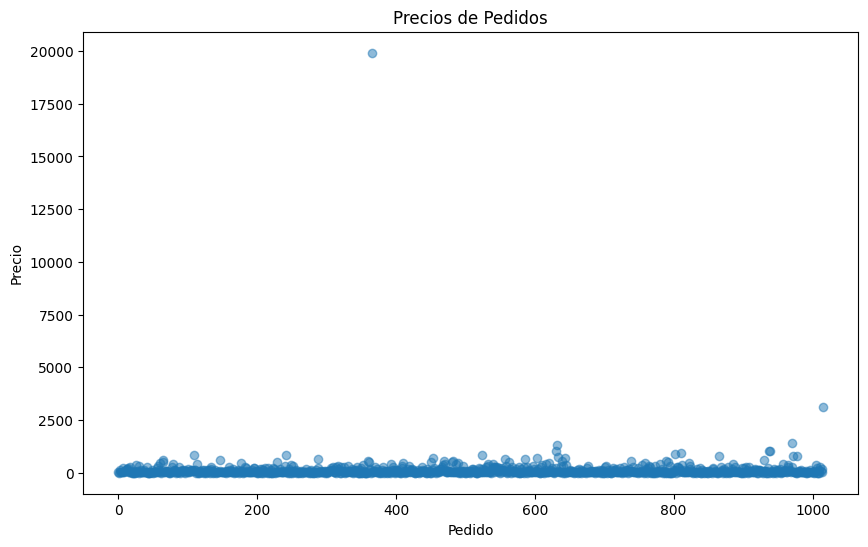

In [19]:
# Graficar el precio de los pedidos
plt.figure(figsize=(10, 6))
plt.scatter(range(len(orders)), orders['revenue'], alpha=0.5)
plt.title('Precios de Pedidos')
plt.xlabel('Pedido')
plt.ylabel('Precio')
plt.show()

# Gráfico de Precios de Pedidos:

La mayoría de los pedidos (puntos) se encuentran en la parte baja del gráfico, con precios relativamente bajos, principalmente por debajo de 2500 unidades monetarias, esto sugiere que la mayoría de los pedidos tienen un precio bajo o moderado, lo cual puede ser típico de la mayoría de los clientes.

Hay un punto claramente fuera de lo común (outlier) en el gráfico con un precio de aproximadamente 20,000 unidades monetarias.
Este valor es significativamente mayor que el resto de los pedidos, lo que indica que uno o unos pocos pedidos tienen precios extremadamente altos.

Además del outlier más extremo, también se observan algunos otros pedidos con precios elevados, aunque no tan altos como el de 20,000 unidades monetaria. Estos puntos se encuentran entre 2500 y 5000 unidades monetarias.

# Conclusiones:
La presencia de un pedido con un precio tan alto en comparación con el resto sugiere que podría tratarse de un caso especial, como una venta de un producto de lujo o una cantidad excepcionalmente grande de productos en un solo pedido. Es importante investigar estos outliers para entender mejor su naturaleza.

También, estos outliers pueden distorsionar el análisis estadístico del conjunto de datos, por lo que podría ser necesario tratarlos por separado o eliminarlos en ciertos análisis.

La concentración de la mayoría de los pedidos en la parte baja del gráfico sugiere que el negocio tiene un mercado principal de productos o servicios de bajo a mediano costo, esto puede ser representativo del poder adquisitivo de la mayoría de los clientes.

Los datos sugieren que el mercado está dividido en dos segmentos principales: un gran volumen de clientes que realizan pedidos de bajo costo y un segmento pequeño de clientes que realizan compras de alto valor. Esto podría ser relevante para estrategias de marketing y pricing.

Sería valioso hacer un análisis más detallado de los pedidos con precios extremadamente altos para entender qué factores contribuyen a esos valores, podría ser un producto especial o una promoción específica que atrae a clientes con un poder adquisitivo significativamente mayor.

In [20]:
# Calcular los percentiles 95 y 99 para los precios de pedidos
price_percentile_95 = orders['revenue'].quantile(0.95)
price_percentile_99 = orders['revenue'].quantile(0.99)

print(f'Percentil 95: {price_percentile_95}')
print(f'Percentil 99: {price_percentile_99}')

Percentil 95: 414.275
Percentil 99: 830.3


In [21]:
# Calcula las conversiones para cada grupo
conversions_A = orders[orders['group'] == 'A']['visitor_id'].nunique()
conversions_B = orders[orders['group'] == 'B']['visitor_id'].nunique()

# Calcula el número total de usuarios en cada grupo
total_users_A = visitors[visitors['group'] == 'A']['visits'].sum()
total_users_B = visitors[visitors['group'] == 'B']['visits'].sum()

# Tasas de conversión
conversion_rate_A = conversions_A / total_users_A
conversion_rate_B = conversions_B / total_users_B

# Realiza la prueba de proporciones Z
count = np.array([conversions_A, conversions_B])
nobs = np.array([total_users_A, total_users_B])
stat, pval = proportions_ztest(count, nobs)

print(f"Estadístico de prueba: {stat:.4f}")
print(f"P-valor: {pval:.4f}")

Estadístico de prueba: -2.5449
P-valor: 0.0109


# Resultados del Test de Significancia estadística de la diferencia en la conversión entre los grupos
Estadístico de prueba (Z): -2.5449
P-valor: 0.0109

# Conclusiones
P-valor < 0.05: El p-valor obtenido es 0.0109, que es menor que el umbral común de 0.05, esto significa que hay una diferencia estadísticamente significativa en la tasa de conversión entre los grupos A y B.

La probabilidad de que la diferencia observada en las tasas de conversión entre los dos grupos sea debida al azar es muy baja (aproximadamente 1.09%). Esto sugiere que una de las estrategias o variaciones utilizadas en el grupo tiene un impacto real en la tasa de conversión.

El valor negativo del estadístico Z (-2.5449) indica que el grupo B (usualmente el segundo grupo) tiene una tasa de conversión mayor que el grupo A (el grupo de control) si seguimos la convención de que un estadístico negativo sugiere que el grupo B es mejor.

Dado que la diferencia es estadísticamente significativa, podríamos recomendar adoptar la estrategia del grupo que mostró una mejor tasa de conversión (probablemente el grupo B). Este grupo podría ser considerado como el "líder" en este experimento A/B.

Podemos considera analizar más a fondo las estrategias aplicadas en ambos grupos para entender qué factores específicos están impulsando la mejora en la tasa de conversión. Podría ser útil realizar pruebas adicionales o verificar los resultados con una muestra más grande para confirmar la consistencia de este hallazgo.

Este resultado sugiere que hay un efecto real en las tasas de conversión debido a la diferencia en las condiciones aplicadas a los grupos, lo que justifica una acción basada en estos hallazgos.

In [22]:
# Filtra el tamaño de los pedidos por grupo
tamanos_pedido_A = orders[orders['group'] == 'A']['revenue']
tamanos_pedido_B = orders[orders['group'] == 'B']['revenue']

# Prueba de Mann-Whitney U (para distribuciones no normales o varianzas desiguales)
u_stat, p_value = st.mannwhitneyu(tamanos_pedido_A, tamanos_pedido_B, alternative='two-sided')

# Realiza la prueba t de Student
t_stat, pval = ttest_ind(tamanos_pedido_A, tamanos_pedido_B, equal_var=False)

print(f'Estadístico de prueba: {t_stat:.4f}')
print(f'P-valor: {p_value:.4f}')

Estadístico de prueba: -0.8345
P-valor: 0.8622


# Resultados del Test de Significancia estadística de la diferencia en el tamaño promedio de pedido 
Se has realizado dos pruebas estadísticas para comparar los tamaños de los pedidos entre dos grupos (A y B):

- Prueba de Mann-Whitney U: Es una prueba no paramétrica que se utiliza cuando no se puede asumir que las distribuciones de los dos grupos sean normales o cuando las varianzas son desiguales.

- Prueba t de Student (independiente): Compara las medias de dos grupos. En este caso, se ha utilizado con la opción equal_var=False, lo que indica que no se asume que las varianzas de los dos grupos sean iguales (conocido como la prueba t de Welch).

# Resultados
Estadístico de prueba: -0.8345
P-valor: 0.8622

# Conclusiones
1. Interpretación del Estadístico de Prueba
Un estadístico de prueba de -0.8345 en el contexto de la prueba t indica que la diferencia entre las medias de los tamaños de los pedidos en los grupos A y B es pequeña y no se aleja mucho de 0 en términos de desviaciones estándar.

En la prueba de Mann-Whitney U, este estadístico compararía las distribuciones de los tamaños de los pedidos entre los dos grupos, y un valor cercano a cero indicaría poca diferencia en las distribuciones.

2. Interpretación del P-valor
Un p-valor de 0.8622 es bastante alto, lo que significa que no hay evidencia suficiente para rechazar la hipótesis nula en ambas pruebas (Mann-Whitney U y t de Student).

La hipótesis nula generalmente establece que no hay diferencia significativa entre los dos grupos (A y B) en términos de los tamaños de los pedidos.

# Conclusión Global
No hay una diferencia significativa en los tamaños de los pedidos entre los grupos A y B. Dado el p-valor alto (0.8622), no hay evidencia estadísticamente significativa para afirmar que los tamaños de los pedidos son diferentes entre los dos grupos.

In [23]:
# Resultados
print(f'Estadístico t de prueba: {t_stat:.4f}')
print(f'P-valor (Prueba t): {pval:.4f}')
print(f'Estadístico U de Mann-Whitney: {u_stat:.4f}')
print(f'P-valor (Mann-Whitney U): {p_value:.4f}')

Estadístico t de prueba: -0.8345
P-valor (Prueba t): 0.4043
Estadístico U de Mann-Whitney: 129041.5000
P-valor (Mann-Whitney U): 0.8622


# Interpretación de los Resultados:

Prueba t de Student:

Estadístico t de prueba: -0.8345. El valor negativo del estadístico t sugiere que, en promedio, el tamaño de los pedidos en el grupo B es ligeramente mayor que en el grupo A. Sin embargo, la magnitud de la diferencia es pequeña.

El p-valor de 0.4043 es significativamente mayor que el umbral comúnmente usado de 0.05. Esto indica que no hay suficiente evidencia para rechazar la hipótesis nula. En otras palabras, la diferencia en el tamaño promedio de los pedidos entre los grupos A y B no es estadísticamente significativa.

Estadístico U de Mann-Whitney: 129041.5000
Este valor no tiene una interpretación directa como en la prueba t, pero se usa para calcular el p-valor.

Un p-valor de 0.8622, mucho mayor que 0.05, también sugiere que no hay evidencia suficiente para rechazar la hipótesis nula. Esto significa que no se encontró una diferencia significativa en la distribución del tamaño de los pedidos entre los dos grupos.

# Conclusiones:

Ambos métodos de prueba (t de Student y Mann-Whitney U) indican que no existe una diferencia estadísticamente significativa en el tamaño promedio de los pedidos entre los grupos A y B.

No se rechaza la hipótesis nula, lo que sugiere que cualquier diferencia observada en los tamaños de los pedidos podría deberse al azar más que a algún efecto real entre los grupos.

La falta de diferencias significativas sugiere que, desde la perspectiva del tamaño promedio de los pedidos, las intervenciones o estrategias aplicadas a los grupos A y B no generaron un impacto distinto. Se podría considerar la posibilidad de experimentar con otras variables o estrategias que podrían tener un impacto más significativo en el tamaño de los pedidos. Alternativamente, podría ser útil examinar otros aspectos del comportamiento del cliente o del negocio que podrían ser más sensibles a las intervenciones.

# Decisión: No hay diferencia entre los grupos.

Ambos métodos de prueba coinciden en que no se observan diferencias significativas entre los grupos, lo cual es un indicativo sólido de que las diferencias observadas en los datos son probablemente atribuibles al azar.

Continuar con la prueba o considerar a uno de los grupos como líder no estaría justificado dado que no se ha demostrado que uno de los grupos sea superior al otro en términos del tamaño promedio de los pedidos.

Concluir que no hay diferencia entre los grupos implica que, desde la perspectiva de los datos actuales, las estrategias o intervenciones aplicadas a los grupos no han tenido un efecto diferenciado. No se necesita continuar la prueba ni seleccionar un grupo como líder.

En resumen, los datos no respaldan la existencia de una diferencia significativa entre los grupos A y B en cuanto al tamaño promedio de los pedidos. Por lo tanto, la prueba debería concluir con la afirmación de que no hay diferencias entre los grupos.